In [1]:
import datetime as dt
import os
import sys
import sqlalchemy as sa
import pandas as pd
import numpy as np

In [2]:
# Setup connection parameters
comp = os.environ["COMPUTERNAME"]  # Get the computer name from environment variables
dbase = "Financial_Securities"     # Define the name of the database

username = os.getlogin()
external_folder_path = 'C:/Users/' + username + '/Documents/Projects/Financial_Securities/Custom_Python_Functions'
sys.path.append(external_folder_path)
from custom_python_functions import create_connection, get_pricing_data, calculate_return, calculate_avg_return
from custom_python_functions import calculate_drawdowns, plot_returns_line_chart, plot_period_returns_by_ticker_box_plot
from custom_python_functions import plot_return_histogram, plot_returns_bubble_chart, plot_ticker_correlations

# Create a connection to the database
s, e = create_connection(comp, dbase, "", "")
s1 = s()  # Instantiate a session object

In [3]:
# Define SQL query to retrieve tickers from the Yahoo_Equity_Prices table
sql_stat = """SELECT 
        TRIM(q2.Ticker) AS Ticker,
        q1.Date,
        ROUND(q1.[Open], 2) AS "Open",
        ROUND(q1.[High], 2) AS "High",
        ROUND(q1.[Low], 2) AS "Low",
        ROUND(q1.[Close], 2) AS "Close",
        q1.Volume AS "Volume"
FROM [Financial_Securities].[Equities].[Yahoo_Equity_Prices] q1
INNER JOIN [Financial_Securities].[Equities].[Equities] q2
ON q1.Ticker_ID = q2.Ticker_ID
ORDER BY q2.Ticker, q1.Date
"""

try:
    # Execute the SQL query and read the results into a DataFrame
    df_pricing = pd.read_sql(sql_stat, s1.bind)
    
except sa.exc.SQLAlchemyError as e:
    # Handle exceptions during SQL query execution
    print(f"Issue querying database tables! Error: {e}")
    s1.close()
    raise

In [4]:
if df_pricing.empty:
    raise ValueError("DataFrame is empty after SQL query.")
    
df_pricing['Date'] = pd.to_datetime(df_pricing['Date'])
df_pricing['Year'] = df_pricing['Date'].dt.year


In [5]:
# Determine the first date for each ticker
first_dates = df_pricing.groupby('Ticker')['Date'].min().reset_index()
first_dates.rename(columns={'Date': 'First Date'}, inplace=True)

# Count how many tickers share the same first date
count_first_dates = first_dates['First Date'].value_counts().reset_index()
count_first_dates.columns = ['First Date', 'Count']

# Filter for first dates that have more than one ticker
valid_first_dates = count_first_dates[count_first_dates['Count'] > 1]['First Date']

# Merge back to keep only those tickers with the same first date
df_pricing = df_pricing.merge(first_dates, on='Ticker', suffixes=('', '_y'))  # Specify suffixes here
df_pricing = df_pricing[df_pricing['First Date'].isin(valid_first_dates)].copy()

df_pricing.drop(columns=['First Date'], inplace=True)
    
if 'First Date_y' in df_pricing.columns:
    df_pricing.drop(columns=['First Date_y'], inplace=True)
    
df_pricing.sort_values(by=['Ticker', 'Date'], inplace=True)
df_ret = calculate_return(df_pricing.copy(), 'Daily')
df_ret.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df_ret.sort_values(by=['Ticker', 'Date'], inplace=True)


In [6]:
portfolio_tickers= ['LLY','SMCI','TRGP','MCK','MRO','PWR','MPC','XOM','FANG','IRM']
df_portfolio_pricing = df_pricing[df_pricing['Ticker'].isin(portfolio_tickers)].copy()
df_portfolio_ret = calculate_avg_return(df_portfolio_pricing.copy(), 'Daily')
df_portfolio_ret['Ticker'] = 'PFL'
df_portfolio_ret.sort_values(by=['Date'], inplace=True)


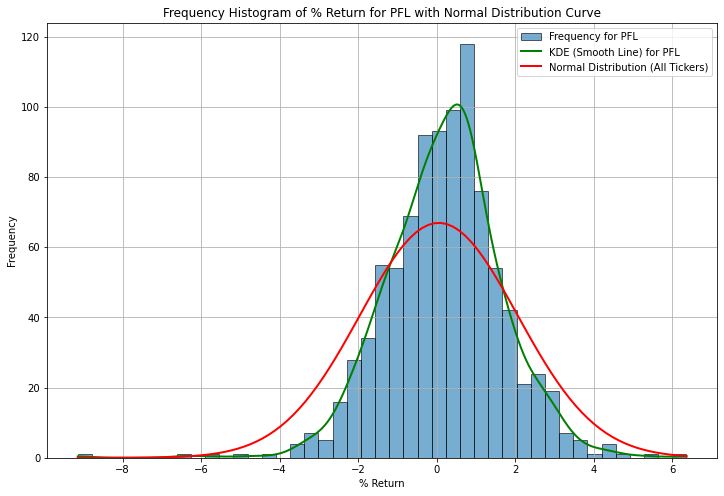

In [7]:
df_ret_comb = pd.concat([df_ret, df_portfolio_ret], axis=0)
df_ret_comb.sort_values(by=['Ticker','Date'], inplace=True)
plot_return_histogram(df_ret_comb, '% Return', 'PFL')


In [8]:
last_dates = df_ret_comb['Date'].max()
three_years_ago = last_dates - pd.DateOffset(days=252 * 3)
three_years_ago_str = three_years_ago.strftime('%Y-%m-%d')

period_label = 'Daily'
date_filter = (df_ret_comb['Date'] >= three_years_ago_str)
df_ret_comb_filter = df_ret_comb.loc[date_filter].copy()  # Adding .copy() here to avoid the warning
df_ret_comb_filter = calculate_drawdowns(df_ret_comb_filter, period_label)
df_ret_comb_last = df_ret_comb_filter.copy().groupby('Ticker').tail(1)
df_ret_comb_last.sort_values(by=['Ticker'], ascending=True, inplace=True)


In [9]:
risk_free_rate = 2.5
df_ret_comb_last['Annualized Sharpe Ratio'] = np.where(
    df_ret_comb_last['Annualized Volatility'] == 0, 
    0, 
    round((df_ret_comb_last['Annualized % Return'] - risk_free_rate) / df_ret_comb_last['Annualized Volatility'], 2)
)
df_ret_comb_last['Annualized Sortino Ratio'] = np.where(
    df_ret_comb_last['Annualized Volatility'] == 0, 
    0, 
    round((df_ret_comb_last['Annualized % Return'] - risk_free_rate) / df_ret_comb_last['Annualized Downside Volatility'], 2)
)
df_ret_comb_last['Calmar Ratio'] = np.where(
    df_ret_comb_last['Max % Drawdown'] == 0, 
    0, 
    round(df_ret_comb_last['Annualized % Return'] / df_ret_comb_last['Max % Drawdown'], 2)
)
df_ret_comb_last.sort_values(by=['Ticker'], ascending=True, inplace=True)


In [10]:
plot_returns_bubble_chart(df_ret_comb_last, 'Annualized % Return', 'Annualized Sharpe Ratio')


In [11]:
plot_returns_bubble_chart(df_ret_comb_last, 'Annualized % Return', 'Annualized Sortino Ratio')

In [12]:
plot_returns_bubble_chart(df_ret_comb_last, 'Annualized % Return', 'Calmar Ratio')

In [13]:
df_pricing_mth = get_pricing_data(df_pricing.copy(), 'Month')

# Determine the first date for each ticker
first_dates = df_pricing_mth.groupby('Ticker')['Date'].min().reset_index()
first_dates.rename(columns={'Date': 'First Date'}, inplace=True)

# Count how many tickers share the same first date
count_first_dates = first_dates['First Date'].value_counts().reset_index()
count_first_dates.columns = ['First Date', 'Count']

# Filter for first dates that have more than one ticker
valid_first_dates = count_first_dates[count_first_dates['Count'] > 1]['First Date']

# Merge back to keep only those tickers with the same first date
df_pricing_mth = df_pricing_mth.merge(first_dates, on='Ticker', suffixes=('', '_y'))  # Specify suffixes here
df_pricing_mth = df_pricing_mth[df_pricing_mth['First Date'].isin(valid_first_dates)].copy()

df_pricing_mth.drop(columns=['First Date'], inplace=True)
    
if 'First Date_y' in df_pricing_mth.columns:
    df_pricing_mth.drop(columns=['First Date_y'], inplace=True)
    
df_bench_ret_mth = calculate_avg_return(df_pricing_mth.copy(), 'Month')

df_bench_ret_mth['Ticker'] = 'BM'
df_bench_ret_mth.sort_values(by=['Year', 'Month'], inplace=True)



In [14]:
portfolio_tickers = ['LLY','SMCI','TRGP','MCK','MRO','PWR','MPC','XOM','FANG','IRM']
df_portfolio_pricing_mth = df_pricing_mth[df_pricing_mth['Ticker'].isin(portfolio_tickers)].copy()
df_portfolio_ret_mth = calculate_avg_return(df_portfolio_pricing_mth.copy(), 'Month')
df_portfolio_ret_mth['Ticker'] = 'PFL'
df_portfolio_ret_mth.sort_values(by=['Year', 'Month'], inplace=True)


In [15]:
df_mth_ret_comb = pd.concat([df_bench_ret_mth, df_portfolio_ret_mth], axis=0)
df_mth_ret_comb.sort_values(by=['Ticker','Year', 'Month'], inplace=True)


In [16]:
plot_returns_line_chart(df_mth_ret_comb, 'Month', 'Month Cumulative % Return')


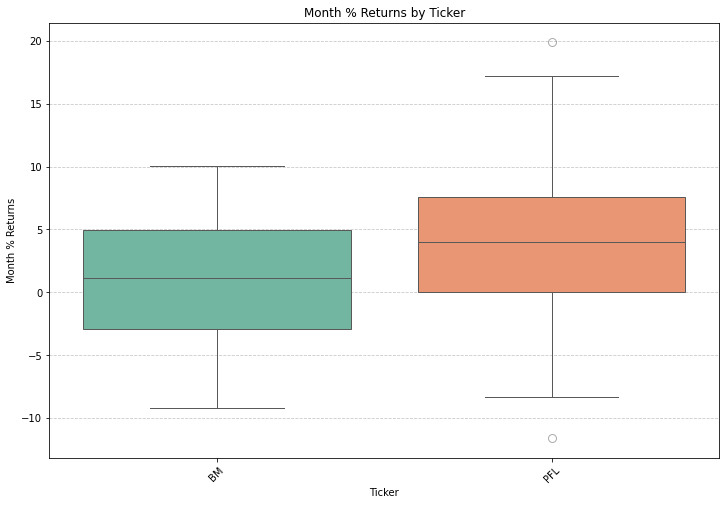

In [17]:
plot_period_returns_by_ticker_box_plot(df_mth_ret_comb, 'Month')


In [18]:
last_dates = df_mth_ret_comb['Date'].max()
three_years_ago = last_dates - pd.DateOffset(days=252 * 3)
three_years_ago_str = three_years_ago.strftime('%Y-%m-%d')

period_label = 'Month'
date_filter = (df_mth_ret_comb['Date'] >= three_years_ago_str)
df_mth_ret_comb_filter = df_mth_ret_comb.loc[date_filter].copy()  # Adding .copy() here to avoid the warning
df_mth_ret_comb_filter = calculate_drawdowns(df_mth_ret_comb_filter, period_label)
df_mth_ret_comb_last = df_mth_ret_comb_filter.copy().groupby('Ticker').tail(1)
df_mth_ret_comb_last = df_mth_ret_comb_last[['Ticker', 'Date', period_label + ' Cumulative % Return', period_label + ' Annualized % Return', period_label + ' Max % Drawdown', period_label + ' Max Drawdown Date']]
df_mth_ret_comb_last.sort_values(by=['Ticker'], ascending=True, inplace=True)

print(df_mth_ret_comb_last.to_string(index=False))


Ticker       Date  Month Cumulative % Return  Month Annualized % Return  Month Max % Drawdown Month Max Drawdown Date
    BM 2024-09-20                      33.93                      11.71                309.03              2022-09-30
   PFL 2024-09-20                     350.30                      57.31                 15.78              2022-09-30


In [19]:
period_label = 'Month'
risk_free_rate = 2.5
df_mth_ret_comb_last = df_mth_ret_comb_filter.copy().groupby('Ticker').tail(1)
df_mth_ret_comb_last[period_label  + ' Annualized Sharpe Ratio'] = np.where(
    df_mth_ret_comb_last[period_label  + ' Annualized Volatility'] == 0, 
    0, 
    round((df_mth_ret_comb_last[period_label  + ' Annualized % Return'] - risk_free_rate) / df_mth_ret_comb_last[period_label  + ' Annualized Volatility'], 2)
)
df_mth_ret_comb_last[period_label  + ' Annualized Sortino Ratio'] = np.where(
    df_mth_ret_comb_last[period_label  + ' Annualized Volatility'] == 0, 
    0, 
    round((df_mth_ret_comb_last[period_label  + ' Annualized % Return'] - risk_free_rate) / df_mth_ret_comb_last[period_label  + ' Annualized Downside Volatility'], 2)
)
df_mth_ret_comb_last[period_label  + ' Calmar Ratio'] = np.where(
    df_mth_ret_comb_last[period_label  + ' Max % Drawdown'] == 0, 
    0, 
    round(df_mth_ret_comb_last[period_label  + ' Annualized % Return'] / df_mth_ret_comb_last[period_label  + ' Max % Drawdown'], 2)
)
df_mth_ret_comb_last = df_mth_ret_comb_last[['Ticker', 'Date', period_label  + ' Annualized Sharpe Ratio', period_label  + ' Annualized Sortino Ratio', period_label  + ' Calmar Ratio']]
df_mth_ret_comb_last.sort_values(by=['Ticker'], ascending=True, inplace=True)

print(df_mth_ret_comb_last.to_string(index=False))


Ticker       Date  Month Annualized Sharpe Ratio  Month Annualized Sortino Ratio  Month Calmar Ratio
    BM 2024-09-20                           0.52                            1.01                0.04
   PFL 2024-09-20                           2.56                            4.47                3.63


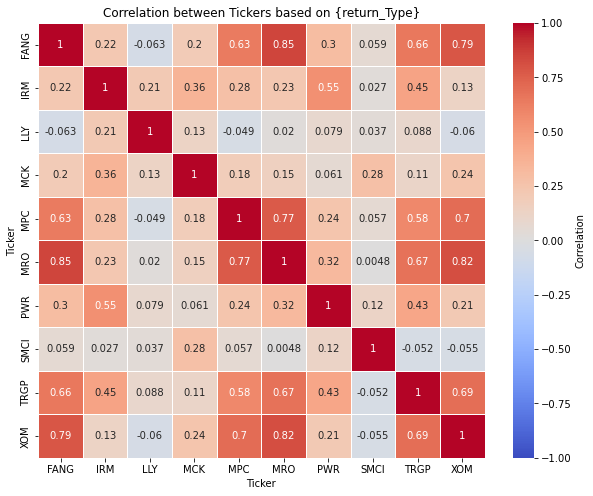

Ticker,FANG,IRM,LLY,MCK,MPC,MRO,PWR,SMCI,TRGP,XOM
Ticker,,,,,,,,,,
FANG,1.000000,0.222028,-0.063260,0.197984,0.634026,0.847214,0.304329,0.059030,0.656195,0.787848
IRM,0.222028,1.000000,0.214451,0.356802,0.276510,0.230264,0.546198,0.026705,0.452528,0.125144
LLY,-0.063260,0.214451,1.000000,0.128732,-0.048829,0.019891,0.079181,0.037217,0.088429,-0.060436
MCK,0.197984,0.356802,0.128732,1.000000,0.181831,0.154520,0.061275,0.280796,0.112314,0.242442
MPC,0.634026,0.276510,-0.048829,0.181831,1.000000,0.767569,0.242390,0.057231,0.584295,0.702430
MRO,0.847214,0.230264,0.019891,0.154520,0.767569,1.000000,0.322779,0.004830,0.672363,0.819835
PWR,0.304329,0.546198,0.079181,0.061275,0.242390,0.322779,1.000000,0.119709,0.434276,0.212343
SMCI,0.059030,0.026705,0.037217,0.280796,0.057231,0.004830,0.119709,1.000000,-0.052230,-0.054556
TRGP,0.656195,0.452528,0.088429,0.112314,0.584295,0.672363,0.434276,-0.052230,1.000000,0.688458


In [21]:
df_portfolio_ret_mth2 = calculate_return(df_portfolio_pricing_mth.copy(), 'Month')
df_portfolio_ret_mth2.sort_values(by=['Year', 'Month'], inplace=True)

plot_ticker_correlations(df_portfolio_ret_mth2, 'Month % Return')
